## NYPD Civilian Complaints EDA:
**Author**: Ryan Hung

**Started**: 7/26/2022

**Completed**: TBD

**Data introduction**: After New York state repealed the statute that kept police disciplinary records secret, known as 50-a, ProPublica filed a records request with New York City’s Civilian Complaint Review Board, which investigates complaints by the public about NYPD officers. The board provided us with records about closed cases for every police officer still on the force as of late June 2020 who had at least one substantiated allegation against them. The records span decades, from September 1985 to January 2020.

**Data source**: https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers

**Analysis Objective**: Clean and wrangle dataset so that insights related to race can be extracted; pave the way for a machine learning model deployment to predict case outcome.

## Notebook breakdown:
1. [Loading in data](#loading-in-our-data)
2. [Data cleaning](#data-cleaning)
3. [EDA](#eda)
3. Age permutation testing
4. Racial hypothesis testing

### Loading in our data:
Before we begin, let's load in our libraries, options, and data.

In [401]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sns.set_theme(style = 'darkgrid', palette='Blues_d')
pd.set_option('display.max_columns', None)

In [41]:
complaints_path = 'data/allegations_202007271729.csv'
layout_path = 'data/CCRB Data Layout Table.xlsx'
excelList = pd.ExcelFile(layout_path).sheet_names # Excel file is separated into multiple sheets
excelList

['Layout', 'Rank Abbrevs', 'Command Abbrevs', 'FADO', 'Dispositions']

In [42]:
layout = pd.read_excel(layout_path)
police_abbrev = pd.read_excel(layout_path, sheet_name=excelList[1]) # Details the full rank behind police abbreviations
dispositions = pd.read_excel(layout_path, sheet_name=excelList[4]) # Describes the meaning behind final verdict
complaints = pd.read_csv(complaints_path) # Dataframe of complaints
complaints.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,rank_now,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,078 PCT,POM,POM,Police Officer,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,PBBS,POM,POM,Police Officer,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,078 PCT,POF,POF,Police Officer,Police Officer,Hispanic,F,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


The dataset comes with a handy dictionary of column names and their descriptions.

In [43]:
layout.drop(columns = "glossary") 

,field name,description
0,unique_mos_id,"unique ID of the officer (""member of service"")"
1,first_name,Officer's first name
2,last_name,Officer's last name
3,command_now,Officer's command assignment as of July 2020
4,complaint_id,Unique ID of the complaint
5,month_received,Month the complaint was received by CCRB
6,year_received,Year the complaint was received by CCRB
7,month_closed,Month the complaint investigation was closed b...
8,year_closed,Year the complaint investigation was closed by...
9,command_at_incident,Officer's command assignment at the time of th...


### Data cleaning:

In [44]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33358 entries, 0 to 33357
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   unique_mos_id             33358 non-null  int64  
 1   first_name                33358 non-null  object 
 2   last_name                 33358 non-null  object 
 3   command_now               33358 non-null  object 
 4   shield_no                 33358 non-null  int64  
 5   complaint_id              33358 non-null  int64  
 6   month_received            33358 non-null  int64  
 7   year_received             33358 non-null  int64  
 8   month_closed              33358 non-null  int64  
 9   year_closed               33358 non-null  int64  
 10  command_at_incident       31814 non-null  object 
 11  rank_abbrev_incident      33358 non-null  object 
 12  rank_abbrev_now           33358 non-null  object 
 13  rank_now                  33358 non-null  object 
 14  rank_i

It seems that the date fields `month_received`, `year_received`, `month_closed`, and `year_closed` can be converted into datetime objects.

In [45]:
complaint_times = complaints[['month_received', 'year_received', 'month_closed', 'year_closed']]
complaint_times.head()

,month_received,year_received,month_closed,year_closed
0,7,2019,5,2020
1,11,2011,8,2012
2,11,2011,8,2012
3,7,2012,9,2013
4,8,2018,2,2019


In [46]:
time_labels = [('month_received', 'year_received'), ('month_closed', 'year_closed')]
times = []

# Creates a list of datetime columns
for label in time_labels:
    times += [pd.to_datetime(complaint_times[label[0]].astype(str) + complaint_times[label[1]].astype(str), format = "%m%Y")]

complaints = complaints.assign(date_received = times[0]).assign(date_closed = times[1])
complaints[['date_received', 'date_closed']].head()

,date_received,date_closed
0,2019-07-01,2020-05-01
1,2011-11-01,2012-08-01
2,2011-11-01,2012-08-01
3,2012-07-01,2013-09-01
4,2018-08-01,2019-02-01


Let's engineer a new feature called `days_taken` which represents the duration, in days, a case took to be closed.

In [47]:
complaints['days_taken'] = (complaints['date_closed'] - complaints['date_received']) # Compute timedelta
complaints[['date_received', 'date_closed', 'days_taken']].head()

,date_received,date_closed,days_taken
0,2019-07-01,2020-05-01,305 days
1,2011-11-01,2012-08-01,274 days
2,2011-11-01,2012-08-01,274 days
3,2012-07-01,2013-09-01,427 days
4,2018-08-01,2019-02-01,184 days


In [48]:
complaints['days_taken'].describe() # Some cases were immediately resolved. Other's took close to a decade.

count                          33358
mean     296 days 06:26:57.507044788
std      152 days 16:52:42.935615560
min                  0 days 00:00:00
25%                183 days 00:00:00
50%                303 days 00:00:00
75%                396 days 00:00:00
max               3348 days 00:00:00
Name: days_taken, dtype: object

Let's inspect all quantative columns.

In [49]:
complaints.describe()

,unique_mos_id,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,mos_age_incident,complainant_age_incident,precinct,days_taken
count,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,28546.000000,33334.000000,33358
mean,18169.912495,6451.608819,23905.058217,6.323551,2010.726782,6.470772,2011.525661,32.346873,32.484201,64.365213,296 days 06:26:57.507044788
std,9566.316896,7945.641596,11954.434138,3.362951,6.034725,3.343372,6.085907,6.040944,28.408963,31.451592,152 days 16:52:42.935615560
min,2.000000,0.000000,517.000000,1.000000,1985.000000,1.000000,1985.000000,20.000000,-4301.000000,0.000000,0 days 00:00:00
25%,9671.000000,1089.000000,13684.750000,3.000000,2007.000000,4.000000,2008.000000,28.000000,23.000000,43.000000,183 days 00:00:00
50%,19215.000000,3691.000000,25132.000000,6.000000,2012.000000,6.000000,2013.000000,31.000000,30.000000,67.000000,303 days 00:00:00
75%,25412.000000,7155.000000,34252.000000,9.000000,2016.000000,9.000000,2016.000000,36.000000,41.000000,81.000000,396 days 00:00:00
max,36374.000000,31977.000000,43703.000000,12.000000,2020.000000,12.000000,2020.000000,60.000000,101.000000,1000.000000,3348 days 00:00:00


The column `complainant_age_incident` has a value of -4301, which is obviously incorrect.

In [50]:
complaints['complainant_age_incident'] = complaints['complainant_age_incident'].apply(lambda age: np.nan if age <= 0 else age) # Replace negative ages with np.nan
complaints['complainant_age_incident'].describe()

count    28538.000000
mean        32.644194
std         12.204035
min          1.000000
25%         23.000000
50%         30.000000
75%         41.000000
max        101.000000
Name: complainant_age_incident, dtype: float64

Let's inspect all qualitative columns by detailing a course of action for each qualitative column.

In [151]:
pd.concat([complaints.select_dtypes(object), complaints['precinct']], axis = 1).nunique()

first_name               1217
last_name                2835
command_now               415
command_at_incident       361
rank_abbrev_incident       18
rank_abbrev_now            20
mos_ethnicity               5
mos_gender                  2
complainant_ethnicity       8
complainant_gender          6
fado_type                   4
allegation                115
contact_reason             53
outcome_description        23
board_disposition          11
rank_incident              15
rank_now                   18
precinct                   79
dtype: int64

- `first_name`, `last_name`, `command_now`, `contact_reason`, `allegation`, and `command_at_incident` all contain dozens if not thousands of unique values that, for simplicity's sake, will be left alone
- `rank_abbrev_incident` and `rank_abbrev_now` have more unique values than `rank_now` and `rank_incident` so converting the abbreviated columns would yield more specific data
- `mos_ethnicity`, `mos_gender`, `complainant_ethnicity`, `complainant_gender`, `fado_type`, `board_disposition`, `precinct`, and `outcome_description` can be manually checked for inconsistencies and cleaned accordingly due to their limited diversity

Certain rows have differing abbreviated ranks but same full ranks.

In [52]:
find_rank_inconsistencies = lambda: complaints[(complaints['rank_abbrev_incident'] != complaints['rank_abbrev_now']) & (complaints['rank_incident'] == complaints['rank_now'])][['rank_abbrev_incident', 'rank_abbrev_now', 'rank_incident', 'rank_now']].head(10)
find_rank_inconsistencies() # Function displaying rows with different abbreviations but same full rank

,rank_abbrev_incident,rank_abbrev_now,rank_incident,rank_now
340,PO,POM,Police Officer,Police Officer
453,DT3,DT2,Detective,Detective
466,SGT,SDS,Sergeant,Sergeant
467,SGT,SDS,Sergeant,Sergeant
468,SGT,SDS,Sergeant,Sergeant
469,SGT,SDS,Sergeant,Sergeant
470,SGT,SDS,Sergeant,Sergeant
471,SGT,SDS,Sergeant,Sergeant
472,SGT,SDS,Sergeant,Sergeant
473,SGT,SDS,Sergeant,Sergeant


To ensure that full ranks stay consistent with their abbreviated ranks, we can convert abbreviated ranks because they are more specific. We can achieve this by joining the `police_abbrev` dataframe with our original dataset.

In [131]:
police_abbrev.head()

,Abbreviation,Rank
0,POM,Police Officer
1,POF,Police Officer
2,PO,Police Officer
3,PSA,Police Officer Special Assignment
4,SGT,Sergeant


In [109]:
def convert_abbrev(police_abbrev, complaints):
    # Merges twice, one for incident rank and one for current rank
    # Performs left join to keep all complaints
    merged = complaints.merge(police_abbrev, how='left', left_on=['rank_abbrev_incident'], right_on =['Abbreviation']).merge(police_abbrev, how = 'left', left_on=['rank_abbrev_now'], right_on=['Abbreviation'], suffixes=("_incident", "_now")).drop(columns = ['rank_now', 'rank_incident', 'Abbreviation_incident', 'Abbreviation_now']).rename(columns = {'Rank_now': 'rank_now', 'Rank_incident': 'rank_incident'})
    return merged

complaints = convert_abbrev(police_abbrev, complaints)

Let's check for values that were unable to be converted.

In [137]:
merged = complaints[['rank_abbrev_incident', 'rank_abbrev_now', 'rank_incident', 'rank_now']] # Finds unconverted abbreviations
print(f"{list(merged[(merged['rank_incident'].isna())]['rank_abbrev_incident'].unique())} does not exist within the police abbreviation dictionary for rank_abbrev_incident")
print(f"{list(merged[(merged['rank_now'].isna())]['rank_abbrev_now'].unique())} does not exist within the police abbreviation dictionary for rank_abbrev_now")

['DET'] does not exist within the police abbreviation dictionary for rank_abbrev_incident
['CCC'] does not exist within the police abbreviation dictionary for rank_abbrev_now


We can now run `find_rank_inconsistencies` to check if merging worked. Certain ranks will still differ in abbreviation but no in rank because their abbreviations in `police_abbrev` convert to the same rank.

In [138]:
display(find_rank_inconsistencies()) # Function displaying rows with different abbreviations but same full rank
display(complaints[['rank_incident', 'rank_now']].nunique())

,rank_abbrev_incident,rank_abbrev_now,rank_incident,rank_now
340,PO,POM,Police Officer,Police Officer
899,PO,POM,Police Officer,Police Officer
900,PO,POM,Police Officer,Police Officer
901,PO,POM,Police Officer,Police Officer
902,PO,POM,Police Officer,Police Officer
903,PO,POM,Police Officer,Police Officer
904,PO,POM,Police Officer,Police Officer
905,PO,POM,Police Officer,Police Officer
906,PO,POM,Police Officer,Police Officer
907,PO,POM,Police Officer,Police Officer


rank_incident    15
rank_now         18
dtype: int64

Now, let's manually sift through features that have a low amount of unique values and look for inconsistencies.

In [152]:
small_qualitative_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 'board_disposition', 'outcome_description', 'precinct']
for feature in small_qualitative_features:
    print("{}'s unique values are: {}".format(feature, complaints[feature].unique()), end='\n\n') # Prints unique values of columns

mos_ethnicity's unique values are: ['Hispanic' 'White' 'Black' 'Asian' 'American Indian']

mos_gender's unique values are: ['M' 'F']

complainant_ethnicity's unique values are: ['Black' nan 'White' 'Asian' 'Refused' 'Hispanic' 'Unknown' 'Other Race'
 'American Indian']

complainant_gender's unique values are: ['Female' 'Male' nan 'Transman (FTM)' 'Not described' 'Transwoman (MTF)'
 'Gender non-conforming']

fado_type's unique values are: ['Abuse of Authority' 'Discourtesy' 'Offensive Language' 'Force']

board_disposition's unique values are: ['Substantiated (Command Lvl Instructions)' 'Substantiated (Charges)'
 'Substantiated (Command Discipline A)'
 'Substantiated (Formalized Training)' 'Unsubstantiated' 'Exonerated'
 'Substantiated (Command Discipline B)' 'Substantiated (Instructions)'
 'Substantiated (Command Discipline)' 'Substantiated (No Recommendations)'
 'Substantiated (MOS Unidentified)']

outcome_description's unique values are: ['No arrest made or summons issued' 'Moving vio

- `complainant_ethnicity` and `complainant_gender` have vague values that should be represented with `np.nan`
- New York contains precincts between 1 and 123, so `precinct` has to conform with this range

In [154]:
def replace_with_nan(complaints):
    columns_to_clean = ['complainant_ethnicity', 'complainant_gender', 'precinct'] # Columns to clean
    replaced_with_nan = complaints.assign(complainant_ethnicity = complaints['complainant_ethnicity'].replace({"Refused": np.nan, 'Unknown': np.nan, 'Other Race': np.nan})).assign(complainant_gender = complaints['complainant_gender'].replace({'Not described': np.nan}))
    replaced_with_nan[(replaced_with_nan['precinct'] > 123) | (replaced_with_nan['precinct'] <= 0)] = np.nan
    for column in columns_to_clean:
        print("{}'s unique values are: {}".format(column, replaced_with_nan[column].unique()), end='\n\n')
    return replaced_with_nan

complaints = replace_with_nan(complaints)

complainant_ethnicity's unique values are: ['Black' nan 'White' 'Asian' 'Hispanic' 'American Indian']

complainant_gender's unique values are: ['Female' 'Male' nan 'Transman (FTM)' 'Transwoman (MTF)'
 'Gender non-conforming']

precinct's unique values are: [ 78.  67.  79.  77.  81.  73.  90.  75. 120.  10.  25. 110.  83.  46.
   9.  28.   1.  68.  70.  72. 122. 113. 101. 100.   7.  13.  71.  23.
 112.  69.  32.  94.  63.  76.  52.  47.  62.  42.  84. 115. 109.   5.
  88.  14. 103. 107. 104.  40. 108.  50.  45.  18. 102. 114.  19.  20.
 106. 105.  17.  60.  34.  44.  48.  41.  43. 111.  49.  26.  30.  33.
   6.  61. 123. 121.  66.  24.  nan  22.]



This is our dataset, now fully cleaned.

In [156]:
complaints.head()

,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,date_received,date_closed,days_taken,rank_incident,rank_now
0,Jonathan,Ruiz,078 PCT,8409.0,42835.0,7.0,2019.0,5.0,2020.0,078 PCT,POM,POM,Hispanic,M,32.0,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),2019-07-01,2020-05-01,305 days,Police Officer,Police Officer
1,John,Sears,078 PCT,5952.0,24601.0,11.0,2011.0,8.0,2012.0,PBBS,POM,POM,White,M,24.0,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274 days,Police Officer,Police Officer
2,John,Sears,078 PCT,5952.0,24601.0,11.0,2011.0,8.0,2012.0,PBBS,POM,POM,White,M,24.0,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274 days,Police Officer,Police Officer
3,John,Sears,078 PCT,5952.0,26146.0,7.0,2012.0,9.0,2013.0,PBBS,POM,POM,White,M,25.0,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges),2012-07-01,2013-09-01,427 days,Police Officer,Police Officer
4,Noemi,Sierra,078 PCT,24058.0,40253.0,8.0,2018.0,2.0,2019.0,078 PCT,POF,POF,Hispanic,F,39.0,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A),2018-08-01,2019-02-01,184 days,Police Officer,Police Officer


### EDA:

Does the length that the complaint is open depend on ethnicity/age/gender? Let's try to visualize this question.

<AxesSubplot:xlabel='complainant_gender', ylabel='days_taken'>

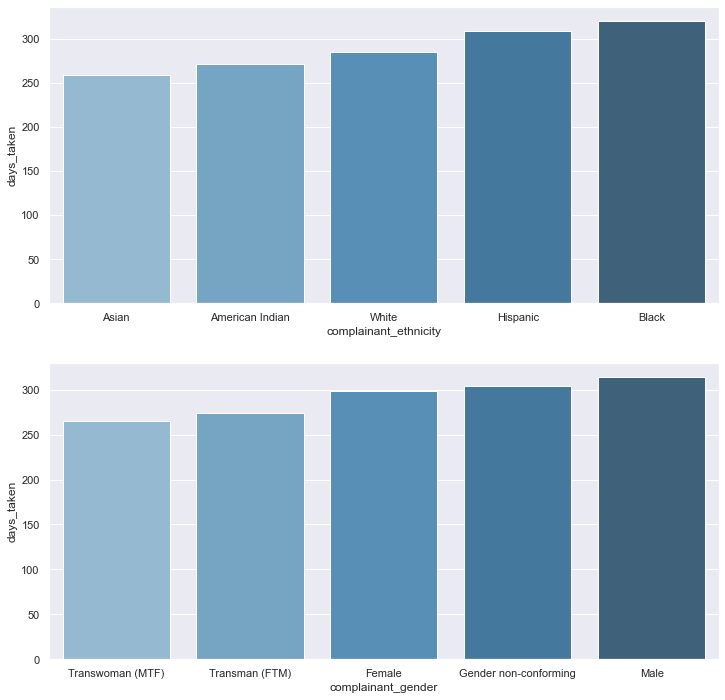

In [402]:
fig, axes = plt.subplots(2, 1, figsize = (12, 12))

complaint_duration_by_ethnicity = pd.concat([complaints['days_taken'].dt.days, complaints['complainant_ethnicity']], axis = 1).groupby("complainant_ethnicity")['days_taken'].mean().sort_values().reset_index() # Calculate average duration for each ethnicity
sns.barplot(data = complaint_duration_by_ethnicity, x = 'complainant_ethnicity', y = 'days_taken', ax=axes[0])

complaint_duration_by_gender = pd.concat([complaints['days_taken'].dt.days, complaints['complainant_gender']], axis = 1).groupby("complainant_gender")['days_taken'].mean().sort_values().reset_index() # Calculate average duration for each gender
sns.barplot(data = complaint_duration_by_gender, x = 'complainant_gender', y = 'days_taken', ax=axes[1])

From the bar graphs, Asian complaints resolve quickest and black complaints resolve slowest. Transwoman complaints resolve quickest while male complaints resolve slowest. Let's conduct a permutation test to see whether the differences between these average case durations are due to chance.

What about age, a quantitative variable, and its effect on case duration?

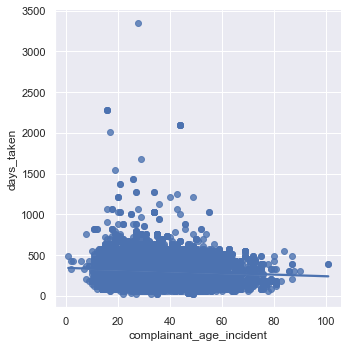

In [358]:
sns.lmplot(data = pd.concat([complaints['days_taken'].dt.days, complaints['complainant_age_incident']], axis = 1), x = "complainant_age_incident", y = 'days_taken')

Let's calculate Pearson correlation coefficient between these two variables.

In [369]:
corr = pd.concat([complaints['days_taken'].dt.days, complaints['complainant_age_incident']], axis = 1).corr().loc['days_taken', 'complainant_age_incident']
print(f"r: {corr}")

r: -0.08829312664488052


The correlation is very low between the two variables, and so it is difficult to determine their relationship. Let's take another approach by grouping ages by intervals of 5, and then plotting the average case duration against each age group.

In [386]:
def assign_age_groups(complaints):
    age_df = pd.DataFrame()
    def round_to_five(age):
        tenths, ones = age//10, age % 10
        if ones >= 0 and ones < 5:
            ones = 0
        else:
            ones = 5
        return str((tenths * 10) + ones) + "-" + str((tenths * 10) + ones + 4)
    age_df['complainant_age_group'] = complaints['complainant_age_incident'].apply(round_to_five)
    return pd.concat([age_df, complaints['days_taken'].dt.days], axis = 1).replace({"nan-nan": np.nan})
age_groups = assign_age_groups(complaints)
age_groups.head()

,complainant_age_group,days_taken
0,35.0-39.0,305.0
1,25.0-29.0,274.0
2,25.0-29.0,274.0
3,45.0-49.0,427.0
4,15.0-19.0,184.0


<AxesSubplot:xlabel='complainant_age_group', ylabel='days_taken'>

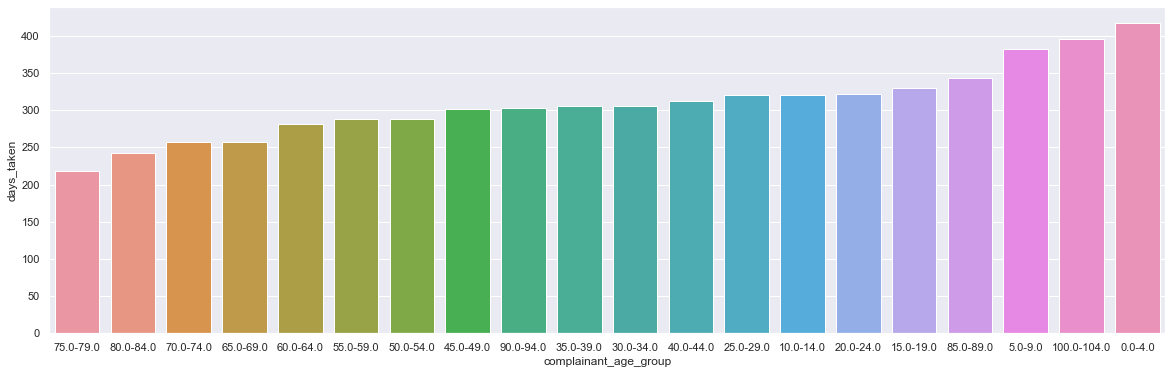

In [404]:
ax = plt.subplots(figsize = (20, 6))
complaint_duration_by_age_groups = age_groups.groupby("complainant_age_group").mean().sort_values(by = 'days_taken').reset_index()
sns.barplot(data = complaint_duration_by_age_groups, x = 'complainant_age_group', y = 'days_taken')

There isn't a clear pattern in the bar plot indicating whether age affects case duration. However, this new approach enables permutation testing because we are comparing categorical distributions to see if there is exists any significant difference:

- Null hypothesis: The distribution of 
- Alternative hypothesis: Of all complaints in New York, the distribution of police officer ages is not equal to  the distribution of complainant ages.
- Test statistic: total variation distance
- Significance level: 0.05

In [ ]:
def calculateTVD(age_probabilities, col1, col2):
    return np.abs((age_probabilities[col1] - age_probabilities[col2])).sum()/2
obs = calculateTVD(age_probabilities, 'mos_age_incident', 'complainant_age_incident')
print("Observed value: {}".format(obs))

Observed value: 0.3701027977559452


An important aspect of this dataframe is the final result of the complaint. This is captured in the column board_disposition. The column has 3 main values corresponding to different decrees according to `dispositions`.

In [ ]:
for index, row in dispositions.iterrows():
    print(row['Disposition'] + ": " + row['Description'], end = "\n\n")
display(cleaned['board_disposition'].unique())

Substantiated: The alleged conduct occurred and it violated the rules. (A breakdown of the types of discipline the CCRB can recommend is here: https://www1.nyc.gov/site/ccrb/prosecution/police-discipline.page) The NYPD can choose to ignore those recommendations. It has discretion over what, if any, discipline is imposed.)

Exonerated: The alleged conduct occurred but did not violate the NYPD’s rules, which often give officers significant discretion over use of force.

Unsubstantiated: The CCRB has fully investigated but could not affirmatively conclude both that the conduct occurred and that it broke the rules.



array(['Substantiated (Command Lvl Instructions)',
       'Substantiated (Charges)', 'Substantiated (Formalized Training)',
       'Unsubstantiated', 'Substantiated (Command Discipline A)',
       'Exonerated', 'Substantiated (Command Discipline B)',
       'Substantiated (Command Discipline)',
       'Substantiated (Instructions)',
       'Substantiated (No Recommendations)', nan,
       'Substantiated (MOS Unidentified)'], dtype=object)

In a society where racial demographics can manipulate a large part in the justice system, we would like to perform a hypothesis test to see if a black complainant who had trouble with a white officer was more likely to be exonerated and thus more likely to lose their case. To do this, we need to quantify the `dispositions` column. We can create a new feature of boolean values in which `True` represents a substantied disposition and `False` represents either exonerated or unsubstantiated.

In [ ]:
def create_disposition_feature(disposition):
    if pd.isnull(disposition):
        return np.nan
    elif "Substantiated" in disposition:
        return True
    else:
        return False

cleaned['did_win_case'] = cleaned['board_disposition'].apply(create_disposition_feature)
cleaned[['did_win_case', 'board_disposition']].head(15)

,did_win_case,board_disposition
0,True,Substantiated (Command Lvl Instructions)
1,True,Substantiated (Charges)
2,True,Substantiated (Charges)
3,True,Substantiated (Charges)
4,True,Substantiated (Formalized Training)
5,False,Unsubstantiated
6,False,Unsubstantiated
7,True,Substantiated (Command Discipline A)
8,True,Substantiated (Command Lvl Instructions)
9,False,Unsubstantiated


In [ ]:
ethnicity_pivot_table = cleaned.pivot_table(index = 'mos_ethnicity', columns='complainant_ethnicity', values='did_win_case', aggfunc='mean')
ethnicity_pivot_table

complainant_ethnicity,American Indian,Asian,Black,Hispanic,White
mos_ethnicity,,,,,
American Indian,NaN,NaN,0.222222,0.000000,0.000000
Asian,0.500,0.459016,0.292115,0.254237,0.403101
Black,0.250,0.189655,0.234715,0.239774,0.323684
Hispanic,0.125,0.265957,0.240627,0.248758,0.267200
White,0.400,0.283912,0.234408,0.242787,0.263670


This pivot table gives us a matrix of probabilities corresponding to the chance that a complainant with a certain ethnicity would win their case against a police officer of a certain ethnicity. We are particularly interested in the probabilities of winning a case against a white police officer, and so let's query that row and plot a distribution.

Text(0, 0.5, 'Chance of winning against white officer')

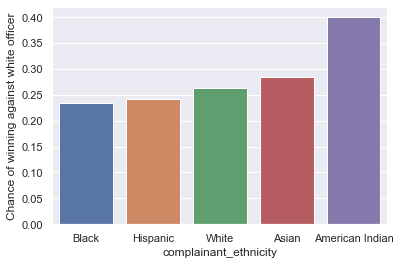

In [ ]:
white_officer_pivot_table = ethnicity_pivot_table.loc['White']
ax = sns.barplot(x = white_officer_pivot_table.sort_values().index, y = white_officer_pivot_table.sort_values())
ax.set_ylabel("Chance of winning against white officer")

It seems that you have a lower chance of winning your complaint if you are a black complainant versus a white officer. Let's conduct a hypothesis test to know if this chance disparity comes from randomness or not. Let's formulate the test:
- Null hypothesis: Race and chance of winning a complaint are not related - the low black proportion is strictly due to chance.
- Alternative hypothesis: Race and chance of winning are related - the chance of winning as a black person against a white officer is lower than that of other races.
- Test statistic: percent chance of success
- P-value: 0.05

In [ ]:
cleaned.pivot_table(index = 'mos_ethnicity', columns='complainant_ethnicity', values='did_win_case', aggfunc='count')

complainant_ethnicity,American Indian,Asian,Black,Hispanic,White
mos_ethnicity,,,,,
American Indian,NaN,NaN,18.0,2.0,2.0
Asian,2.0,61.0,558.0,236.0,129.0
Black,4.0,58.0,2846.0,709.0,380.0
Hispanic,8.0,94.0,4721.0,2215.0,625.0
White,50.0,317.0,8963.0,3258.0,1646.0


The above table shows the counts of each racial interaction. There are 8963 black complainants against white officers. Thus, our hypothesis test can be summarized by the fact that if we randomly sample 8963 complainants from a general population of complainants that are against white officers, calculate the percent chance of success, and then compare to our observed statistic, we would either see negligible difference or significant difference.

In [ ]:
def racial_hypoth(cleaned, N):
    obs = ethnicity_pivot_table.loc['White', 'Black']
    only_white_officer = cleaned[(cleaned['mos_ethnicity'] == 'White') & (~cleaned['mos_ethnicity'].isna())]['did_win_case']
    probabilities = np.random.choice(only_white_officer, size = (N, 8963)).mean(axis = 1)
    return probabilities, np.mean(probabilities <= obs), obs
probabilities, p_val, obs = racial_hypoth(cleaned, 5000)
ax = pd.Series(probabilities).plot(kind = 'hist', bins = 30, ec = 'black', alpha = .5)
plt.axvline(obs, color = 'red')

In [ ]:
print("P-value is: {}".format(p_val))

P-value is: 0.059


Because our p-value is 0.0552, which is greater than our set 0.05 significance level, we fail to reject the null hypothesis that race and chance of winning are not related. However, this doesn't mean that race and chance of winning a complaint aren't completely unrelated!

### Gender exploration:
Now, let's see if we can find any interesting insights towards how gender might play a role in our data.

What are the gender proportions for officers? For complainants?

In [ ]:
display(cleaned['mos_gender'].value_counts(normalize = True))
display(cleaned['complainant_gender'].value_counts(normalize = True))

M    0.947092
F    0.052908
Name: mos_gender, dtype: float64

Male                     0.826670
Female                   0.172402
Transwoman (MTF)         0.000688
Transman (FTM)           0.000172
Gender non-conforming    0.000069
Name: complainant_gender, dtype: float64

What are the top reasons why an officer made contact for each complainant gender group? Why the complainant had a complaint in the first place?

In [ ]:
most_common_reasons_by_gender = cleaned.groupby("complainant_gender").agg(lambda series: series.value_counts().index[0])[['fado_type', 'allegation', 'contact_reason']]
most_common_reasons_by_gender.style.set_caption("Most common reasons by gender")

,fado_type,allegation,contact_reason
complainant_gender,,,
Female,Abuse of Authority,Word,PD suspected C/V of violation/crime - street
Gender non-conforming,Abuse of Authority,Interference with recording,C/V at PCT to file complaint of crime
Male,Abuse of Authority,Physical force,PD suspected C/V of violation/crime - street
Transman (FTM),Discourtesy,Word,Report-dispute
Transwoman (MTF),Abuse of Authority,Gender,PD suspected C/V of violation/crime - street


What are the general win percentages for each gender? What about the general duration it took for these cases?

In [ ]:
pd.concat([cleaned.groupby("complainant_gender")[['did_win_case']].mean(), cleaned.groupby("complainant_gender")[['days_taken']].mean()], axis= 1)

,did_win_case,days_taken
complainant_gender,,
Female,0.205583,298 days 19:51:20.279162512
Gender non-conforming,1.000000,304 days 00:00:00
Male,0.255666,314 days 04:46:53.889466464
Transman (FTM),0.400000,274 days 00:00:00
Transwoman (MTF),0.550000,264 days 19:12:00


Do females have a higher complaint success rate than men for the same allegations? Let's use fado_type, which is a generalization of the allegation column and thus has less unique values.

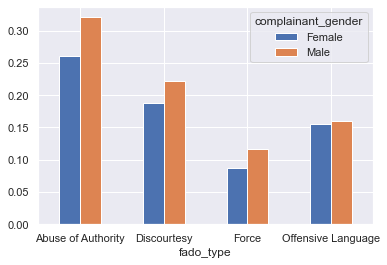

In [ ]:
gender_and_allegation_table_obs = cleaned.pivot_table(index = 'complainant_gender', columns = 'fado_type', values='did_win_case', aggfunc="mean", fill_value=0)
gender_and_allegation_table_obs.loc[['Female', 'Male'], :].T.plot(kind = 'bar')
x = plt.xticks(rotation = 'horizontal')

Interesting! It seems that, across all types of complaints, women lose a disproportionate amount of their cases than men do. Because we are comparing the categorical distribution of win percentage for females against the categorical distribution of win percentage for males without knowledge of the *correct* probability model, let's formulate a permutation test:
- Null hypothesis: the distribution of percent chance of winning a complaint for men is the same as that for females.
- Alternative hypothesis: the distribution of percent chance of winning a complaint as a female is less than that for men.
- Test statistic: sum of proportion differences between female and men 
- Significance level: 0.05

In [ ]:
def permutation(cleaned, N):
    obs = gender_and_allegation_table_obs.diff(-1).loc['Female'].sum()
    stats = []
    for _ in range(N):
        gender_and_allegation = cleaned[['complainant_gender', 'fado_type', 'did_win_case']].copy()
        gender_and_allegation['shuffled_gender'] = np.random.permutation(gender_and_allegation['complainant_gender'])
        gender_and_allegation_table = gender_and_allegation.pivot_table(index = 'shuffled_gender', columns = 'fado_type', values='did_win_case', aggfunc="mean", fill_value=0).loc[['Female', 'Male'], :]
        stats.append(gender_and_allegation_table.diff(-1).loc['Female'].sum())
    ax = pd.Series(stats).plot(kind = 'hist').axvline(obs)
    plt.axvline(np.percentile(stats, 5), color = 'red')
    return np.mean(np.array(stats) <= obs)
print("P-value: {}".format(permutation(cleaned, 400)))

KeyboardInterrupt: 

Our p-value states that there is a 0 percent chance of seeing our observed value in our general population. Thus, we reject the null hypothesis in favor of the alternative. This, however, does not confirm that females lose more cases on average than men.

### Lingering thoughts and questions:
- In this notebook, all my inferential testing preceeded my missing data analysis and imputation steps. Should I continue to ignore missing values during my inferences? Or, would it be better, in the future, for me to deal with missing data first?
- If two distributions contain largely different amounts of values, how should I scale such data for inferential testing?
- Melting is definitley difficult to wrap my head around. However, looking at some graphics and animations helped.
- Is there a way to determine Simpson's paradox without domain knowledge while I perform my aggregations?